<a href="https://colab.research.google.com/github/reddragon/book-codelabs/blob/main/Data_Quantization_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Quantization Colab

In this section, we will learn how to experiment with quantization.

## Defining the basic Quantization & Dequantization methods.

In [2]:
# numpy is one of the most useful libraries for ML.
import numpy as np

def get_scale(x_min, x_max, b):
  # Compute scale as discussed.
  return (x_max - x_min ) * 1.0 / (2**b)

"""Quantizing the given vector x."""
def quantize(x, x_min, x_max, b):
  # Clamp x to lie in [x_min, x_max].
  x = np.minimum(x, x_max)
  x = np.maximum(x, x_min)

  # Compute scale as discussed.
  s = get_scale(x_min, x_max, b)
  x_q = np.floor((x - x_min) / s)

  # Clamping the quantized value to be less than (2^b - 1).
  x_q = np.minimum(x_q, 2**b - 1)

  # Return x_q as an unsigned integer.
  # uint8 is the smallest data type supported by numpy.
  return x_q.astype(np.uint8)

In [3]:
# Construct the array that we wish to quantize. 
# We slightly exceed 10.0 to include 10.0 in our range.
x = np.arange(-10.0, 10.0 + 1e-6, 2.5)
print(x)

[-10.   -7.5  -5.   -2.5   0.    2.5   5.    7.5  10. ]


In [4]:
# Quantize the entire array in one go.
x_q = quantize(x, -10.0, 10.0, 3)
print(x_q)

[0 1 2 3 4 5 6 7 7]


In [5]:
def dequantize(x_q, x_min, x_max, b):
  # Compute the value of r the same way.
  s = get_scale(x_min, x_max, b)
  x = x_min + (s * x_q)
  return x

In [6]:
dequantize(x_q, -10.0, 10.0, 3)

array([-10. ,  -7.5,  -5. ,  -2.5,   0. ,   2.5,   5. ,   7.5,   7.5])

## Mars Rover Problem

Let's try to simulate quantization on images. 

Image Source: [NASA](https://www.nasa.gov/sites/default/files/styles/full_width_feature/public/thumbnails/image/pia23378-16.jpg)

In [7]:
!wget https://github.com/reddragon/book-codelabs/raw/main/pia23378-16.jpeg

--2021-06-11 02:04:58--  https://github.com/reddragon/book-codelabs/raw/main/pia23378-16.jpeg
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/reddragon/book-codelabs/main/pia23378-16.jpeg [following]
--2021-06-11 02:04:58--  https://raw.githubusercontent.com/reddragon/book-codelabs/main/pia23378-16.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 129737 (127K) [image/jpeg]
Saving to: ‘pia23378-16.jpeg’

pia23378-16.jpeg    100%[===================>] 126.70K  --.-KB/s    in 0.04s   

2021-06-11 02:04:58 (3.26 MB/s) - ‘pia23378-16.jpeg’ saved [129737/129737]



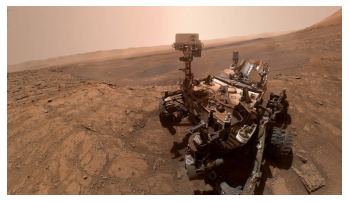

In [8]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = (mpimg.imread('pia23378-16.jpeg') / 255.0)
plt.axis('off')
plt.imshow(img)

In [9]:
img_min = np.min(img)
img_max = np.max(img)
print('Min: %d, Max: %d' % (img_min, img_max))

Min: 0, Max: 1


In [10]:
def simulate_transmission(img, b):
  transmitted_image = quantize(img, 0.0, 1.0, b)
  decoded_image = dequantize(transmitted_image, 0.0, 1.0, b)
  plt.axis('off')
  plt.imshow(decoded_image) 

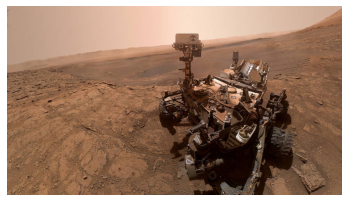

In [11]:
simulate_transmission(img, 8)

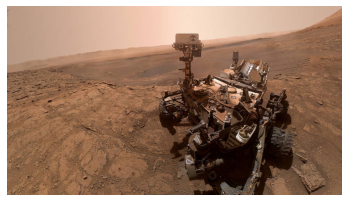

In [12]:
simulate_transmission(img, 8)

## Simulating Quantization on a Dummy Fully-Connected layer

In [13]:
# Set the seed so that we get the same initialization.
np.random.seed(10007)

def get_random_matrix(shape):
  return np.random.uniform(low=-1.0, high=1.0, size=shape)

# Populate the inputs, weights and bias.
inputs = get_random_matrix([10,3])
weights = get_random_matrix([3,5])
bias = get_random_matrix([5])

In [14]:
print(weights)

[[-0.08321415 -0.66657766  0.71264132 -0.39179407  0.05601718]
 [-0.85867389 -0.00864216 -0.15913464 -0.00676971  0.33190099]
 [-0.25760764 -0.82441528  0.57125625  0.74180458 -0.75251044]]


In [15]:
y = np.matmul(inputs, weights) + bias
print(y)

[[ 0.00511569 -0.89318885  0.51116489  0.57396818 -0.34144945]
 [ 1.34222938 -0.1270941   0.34179184 -0.75315659  0.39381581]
 [ 0.9916536  -1.15636837  0.96734553  0.53233659 -0.7927911 ]
 [ 0.43675795 -1.26224397  0.95964283  0.53281738 -0.62054885]
 [ 1.13107671  0.0891375  -0.02051028 -0.25658162  0.20175099]
 [-0.25101365 -0.83651706  0.45385709  0.36579153 -0.07140417]
 [ 0.05000226  0.02090654 -0.06632239 -0.70140683  0.91099702]
 [ 0.33570299 -1.31070844  1.04055933  0.29474841 -0.42930995]
 [ 0.1520569  -0.61360656  0.62168381 -0.96024268  0.81257321]
 [ 0.05897928 -0.03343131 -0.041293   -0.57477116  0.79554345]]


In [16]:
y = np.maximum(y, 0)
print(y)

[[0.00511569 0.         0.51116489 0.57396818 0.        ]
 [1.34222938 0.         0.34179184 0.         0.39381581]
 [0.9916536  0.         0.96734553 0.53233659 0.        ]
 [0.43675795 0.         0.95964283 0.53281738 0.        ]
 [1.13107671 0.0891375  0.         0.         0.20175099]
 [0.         0.         0.45385709 0.36579153 0.        ]
 [0.05000226 0.02090654 0.         0.         0.91099702]
 [0.33570299 0.         1.04055933 0.29474841 0.        ]
 [0.1520569  0.         0.62168381 0.         0.81257321]
 [0.05897928 0.         0.         0.         0.79554345]]


In [17]:
w_min = np.min(weights)
w_max = np.max(weights)
print(w_min, w_max)

-0.8586738858321132 0.7418045798990329


In [18]:
weights_quantized = quantize(weights, w_min, w_max, 8)
print(weights_quantized)

[[124  30 251  74 146]
 [  0 135 111 136 190]
 [ 96   5 228 255  16]]


In [19]:
weights_dequantized = dequantize(weights_quantized, w_min, w_max, 8)
print(weights_dequantized)

[[-0.08344213 -0.67111782  0.71054523 -0.39603558  0.05409899]
 [-0.85867389 -0.01467157 -0.16471643 -0.0084197   0.32918123]
 [-0.25849446 -0.82741454  0.56675225  0.73555271 -0.75864398]]


In [20]:
print(weights)

[[-0.08321415 -0.66657766  0.71264132 -0.39179407  0.05601718]
 [-0.85867389 -0.00864216 -0.15913464 -0.00676971  0.33190099]
 [-0.25760764 -0.82441528  0.57125625  0.74180458 -0.75251044]]


In [21]:
np.sqrt(np.mean((weights_dequantized - weights) ** 2))

0.003925407435722753

In [22]:
y_via_quant = np.maximum(np.matmul(inputs, weights_dequantized) + bias, 0)
print(y_via_quant)

[[0.00465006 0.         0.50726087 0.57192647 0.        ]
 [1.34289989 0.         0.34965774 0.         0.40061985]
 [0.99103964 0.         0.96913415 0.53045113 0.        ]
 [0.43607818 0.         0.95754279 0.52921343 0.        ]
 [1.13163941 0.09731423 0.         0.         0.20744122]
 [0.         0.         0.44860521 0.36376202 0.        ]
 [0.05074402 0.01993939 0.         0.         0.91419542]
 [0.33511031 0.         1.03784683 0.290782   0.        ]
 [0.15252488 0.         0.62064439 0.         0.81421158]
 [0.05962415 0.         0.         0.         0.79821172]]


In [23]:
print(y)

[[0.00511569 0.         0.51116489 0.57396818 0.        ]
 [1.34222938 0.         0.34179184 0.         0.39381581]
 [0.9916536  0.         0.96734553 0.53233659 0.        ]
 [0.43675795 0.         0.95964283 0.53281738 0.        ]
 [1.13107671 0.0891375  0.         0.         0.20175099]
 [0.         0.         0.45385709 0.36579153 0.        ]
 [0.05000226 0.02090654 0.         0.         0.91099702]
 [0.33570299 0.         1.04055933 0.29474841 0.        ]
 [0.1520569  0.         0.62168381 0.         0.81257321]
 [0.05897928 0.         0.         0.         0.79554345]]


In [24]:
np.sqrt(np.mean((y_via_quant - y) ** 2))

0.002573583625884542